# Obtain company embedding from descriptive features

In [1]:
import os
import pandas as pd
import numpy as np
import gensim.downloader as api
import logging
logging.basicConfig(format='%(asctime)s : %(threadName)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim.parsing.preprocessing import preprocess_documents, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, preprocess_string
pcwd = os.getcwd()


In [2]:
# Only load once
glove = api.load("glove-wiki-gigaword-100")

2019-11-02 03:28:59,569 : MainThread : INFO : loading projection weights from /Users/lelecao/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz
2019-11-02 03:29:43,724 : MainThread : INFO : loaded (400000, 100) matrix from /Users/lelecao/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz


In [3]:
# Load train data
df = pd.read_pickle("../data/train.pkl")
df[df['investor_names_concat'].notnull()].loc[[563740]].transpose()

,563740
company_name,PCD Partners
homepage_url,com
country_code,USA
city,Lebanon
short_description,PCD Partners is a group of world class physici...
description,PCD Partners is a group of world class physici...
employee_count,1-10
weeks_founded,405.143
company_uuid,9fc2313a-05e8-16cb-9094-3a0ba11baec8
weeks_founded_quant,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


## Prepare sentence embedding training data

In [4]:
df = df[['company_name', 'short_description', 'description', 'homepage_url', 
         'investor_names_concat']] # note that no short_description is null

# flattern investor_names_concat
def flattern_investor_names_concat(x):
    result = ""
    if type(x) is not list:
        return result
    else:
        for entry in x:
            if type(entry) is str and len(entry) > 1:
                result += (" " + entry)
    return result
df['investor_names_concat'] = df['investor_names_concat'].apply(flattern_investor_names_concat)
df[df['investor_names_concat'] != ""].head(n=2)


,company_name,short_description,description,homepage_url,investor_names_concat
461,myrestaurant.com,MyRestaurant is a project with Portuguese soul...,MyRestaurant is a project with Portuguese soul...,pt,startup braga
483,Reculta,A campus recruitment solution provider.,A short video describing what Reculta does and...,com,ciie


In [5]:
# Merge into one sentence
df = df.replace(np.nan, '', regex=True)
# df['org_desc'] = df.company_name + ' MYSEP ' + df.short_description + ' MYSEP ' + df.description
# for simplisity, do not use any sep word here
df['org_desc'] = df.company_name + ' ' + df.short_description + ' ' + df.description + ' ' + df.homepage_url + df.investor_names_concat
df_list = df['org_desc'].tolist()
print(df_list[:2])

['BN Media BN Media is an entity that features three cross promoted faith and inspiration brands including Affinity4, Beliefnet, and Cross Bridge. The mission of BN Media is to serve the vast online market for spirituality and inspiration, bringing audio-visual and written content to the masses while helping people make a difference for their favorite nonprofit organization. BN Media achieves this by bridging the gap through which ordinary activities inspire activism, online giving, and volunteerism. com', 'BSN Glasspack The second-largest glass container maker in Europe  com']


In [6]:
# Caution: this may take some time
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, 
                  strip_multiple_whitespaces, strip_numeric, remove_stopwords]
df_list_processed = []
for s in df_list:
    df_list_processed.append(preprocess_string(s, CUSTOM_FILTERS))
print(df_list_processed[:2])


[['bn', 'media', 'bn', 'media', 'entity', 'features', 'cross', 'promoted', 'faith', 'inspiration', 'brands', 'including', 'affinity', 'beliefnet', 'cross', 'bridge', 'mission', 'bn', 'media', 'serve', 'vast', 'online', 'market', 'spirituality', 'inspiration', 'bringing', 'audio', 'visual', 'written', 'content', 'masses', 'helping', 'people', 'difference', 'favorite', 'nonprofit', 'organization', 'bn', 'media', 'achieves', 'bridging', 'gap', 'ordinary', 'activities', 'inspire', 'activism', 'online', 'giving', 'volunteerism', 'com'], ['bsn', 'glasspack', 'second', 'largest', 'glass', 'container', 'maker', 'europe', 'com']]


## Finetune the word embedding

In [7]:
# Format training dataset
from fse import IndexedList
s = IndexedList(df_list_processed)
print(len(s))
# s.items

563747


In [8]:
# Train!
from fse.models.average import FAST_VERSION, MAX_WORDS_IN_BATCH
print(MAX_WORDS_IN_BATCH, FAST_VERSION)
from fse.models import SIF
model = SIF(glove, workers=2)
model.train(s)

2019-11-02 03:31:03,572 : MainThread : INFO : scanning all indexed sentences and their word counts


10000 1


2019-11-02 03:31:04,676 : MainThread : WARNING : found 22 empty sentences
2019-11-02 03:31:04,676 : MainThread : INFO : finished scanning 563747 sentences with an average length of 50 and 28472922 total words
2019-11-02 03:31:04,867 : MainThread : INFO : estimated memory for 563747 sentences with 100 dimensions and 400000 vocabulary: 369 MB (0 GB)
2019-11-02 03:31:04,868 : MainThread : INFO : initializing sentence vectors for 563747 sentences
2019-11-02 03:31:07,061 : MainThread : INFO : pre-computing SIF weights for 400000 words
2019-11-02 03:31:07,292 : MainThread : INFO : begin training
2019-11-02 03:31:12,303 : MainThread : INFO : PROGRESS : finished 52.77% with 297466 sentences and 14196086 words, 59493 sentences/s
2019-11-02 03:31:17,104 : MainThread : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-02 03:31:17,105 : MainThread : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-02 03:31:18,930 : MainThread : INFO : computing 1 prin

(563725, 26904669)

## Model qualitative healthchecks

In [9]:
# Prediction health-check
tmp = ("service auto mobile lagacy".split(), 0)
print(model.infer([tmp]))

2019-11-02 03:31:19,344 : MainThread : INFO : scanning all indexed sentences and their word counts
2019-11-02 03:31:19,346 : MainThread : INFO : finished scanning 1 sentences with an average length of 4 and 4 total words
2019-11-02 03:31:19,347 : MainThread : INFO : removing 1 principal components took 0s


[[-0.05434328 -0.22653261 -0.02261662 -0.02114012 -0.03559867 -0.4116801
   0.08800721  0.06333081  0.22072472 -0.01645608 -0.0956677  -0.08060533
  -0.33372235 -0.06290601 -0.10216651 -0.14771338  0.478073   -0.12044575
   0.13663782 -0.05920042  0.32496768 -0.12894481  0.12092359  0.39044452
   0.4104718  -0.25776392 -0.21415451  0.29821783  0.23741129  0.24658053
   0.06917958 -0.09804392  0.06770027 -0.21533725  0.26988322  0.14965504
  -0.25745928 -0.22102167  0.51207805  0.23689328  0.637272   -0.10560831
   0.16473857  0.17959264 -0.00458754  0.13765529  0.21556571  0.07714697
   0.46809906 -0.14634466 -0.0370268   0.10116825 -0.24010336 -0.36941212
   0.18917093  0.47260916 -0.3213988   0.14230813  0.4971174   0.2658073
   0.2959516  -0.42634827  0.26980257  0.06192587 -0.4084633   0.14585271
  -0.36903965  0.0113853   0.09371829  0.389447   -0.02849906 -0.24862216
   0.01343626 -0.17013204  0.48312008  0.34568548  0.64777964  0.29259714
  -0.16098714 -0.53036904  0.3886639  -0

In [10]:
# Similarity healthcheck
print(s[9])
print(s[5])
print(model.sv.similarity(9,5).round(3))
print(s[0])
print(s[4])
print(model.sv.similarity(0,4).round(3))

(['innovaction', 'lab', 'innovactionlab', 'non', 'profit', 'organization', 'conducts', 'seminars', 'trial', 'pitches', 'enable', 'growth', 'entrepreneurs', 'innovactionlab', 'non', 'profit', 'organization', 'conducts', 'seminars', 'trial', 'pitches', 'enable', 'growth', 'entrepreneurs', 'courses', 'free', 'students', 'years', 'age', 'innovactionlab', 'founded', 'based', 'rome', 'italy', 'org'], 9)
(['park', 'insurance', 'company', 'park', 'insurance', 'company', 'company', 'offering', 'commercial', 'vehicle', 'insurance', 'services', 'businesses', 'com'], 5)
-0.192
(['bn', 'media', 'bn', 'media', 'entity', 'features', 'cross', 'promoted', 'faith', 'inspiration', 'brands', 'including', 'affinity', 'beliefnet', 'cross', 'bridge', 'mission', 'bn', 'media', 'serve', 'vast', 'online', 'market', 'spirituality', 'inspiration', 'bringing', 'audio', 'visual', 'written', 'content', 'masses', 'helping', 'people', 'difference', 'favorite', 'nonprofit', 'organization', 'bn', 'media', 'achieves', 'b

### TSNE Visualization

In [11]:
z = model.sv.vectors
idx = np.random.choice(z.shape[0], 1000, replace=False)
z = z[idx, :]
distance = []
print('center sentence: {}'.format(df_list[4]))
for entry in idx:
    distance.append((entry, model.sv.similarity(4, entry)))

center sentence: NameEngine NameEngine is a website providing correct name pronunciations of athletes, entertainers, musicians, brands, and more.  com


In [12]:
dist_sort = sorted(distance, key=lambda x: x[1])
print('Top 3 relatives:')
for i in range(3):
    entry = dist_sort[-(i+1)]
    print('No.{}-(dist={}): {}'.format(i, entry[-1], df_list[entry[0]]))

print('\n3 least-alike companies:')
for i in range(3):
    entry = dist_sort[i]
    print('No.{}-(dist={}): {}'.format(i, entry[-1], df_list[entry[0]]))

Top 3 relatives:
No.0-(dist=0.5264273881912231): Interviewher.com a website for women Interviewher.com is a platform that exposes women owned businessness nationally and internationally through interviews and a recently launched social network.   This website inspires current and future women entrepreneurs while showcasing companies women love in different cities.   The Interviewher.com Community allows women and companies to log in, create their profiles and connect with one another. Companies can post job opportunities, network with other companies, share coupons/promotions/discounts and even post private sales.   Women can connect with their favorite companies, receive coupons/discounts/shop private sales, participate in giveaways, find jobs and more! com
No.1-(dist=0.4753102660179138): Nanoogo Nanoogo is an online platform for kids to share their thoughts and creativity. Kids are creative and talented in many ways - Could be a great writer, artist or the next Edison. On Nanoogo, ki

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
tsne_res = tsne.fit_transform(z)
res_pd = pd.DataFrame(tsne_res)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.194s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.444535
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.404114
[t-SNE] KL divergence after 1000 iterations: 1.785238


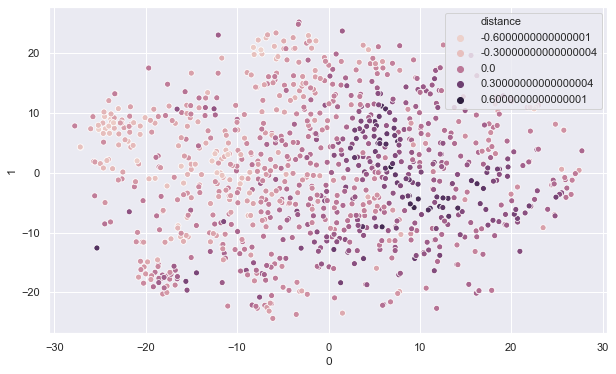

In [16]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
res_pd['distance'] = [x[1] for x in distance]
res_pd
ax = sns.scatterplot(x=0, y=1, hue="distance", data=res_pd)

## Does investors have general preference?
(done in EDA notebook)

## Dump the sentence embedding model

In [15]:
import pickle
outfile = open('../model/semdb_model.pkl','wb')
pickle.dump(model, outfile)
outfile.close()